# Testing of packaged pitch tracking algorithms

## Test with Sine Wave

done computing


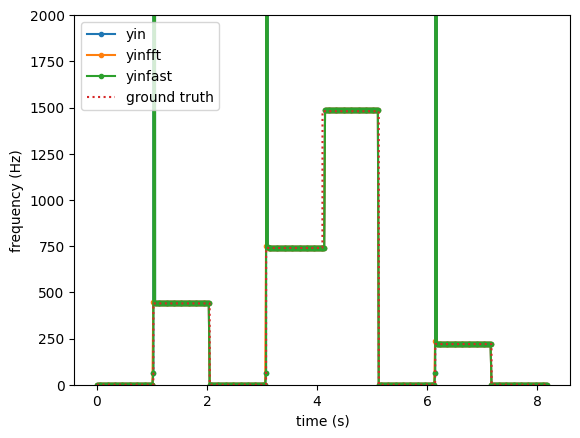

In [2]:
import numpy as np
import aubio

def build_sinusoid(length, freqs, samplerate):
    return np.sin( 2. * np.pi * np.arange(length) * freqs / samplerate).astype(aubio.float_type)

def run_pitch(p, input_vec):
    cands = []
    for vec_slice in input_vec.reshape((-1, p.hop_size)):
        a = p(vec_slice)[0]
        cands.append(a)
    return cands


methods = ['yin', 'yinfft', 'yinfast']


cands = {}
buf_size = 2048//2
hop_size = 512//2
samplerate = 16000
sin_length = (samplerate * 10) % 512 * 512
freqs = np.zeros(sin_length)

partition = sin_length // 8
pointer = 0

pointer += partition
freqs[pointer: pointer + partition] = 440

pointer += partition
pointer += partition
freqs[ pointer : pointer + partition ] = 740

pointer += partition
freqs[ pointer : pointer + partition ] = 1480

pointer += partition
pointer += partition
freqs[ pointer : pointer + partition ] = 220

# pointer += partition
# pointer += partition
# freqs[ pointer : pointer + partition ] = 400 + 5 * np.random.random(sin_length//8)   BREAKS IT

a = build_sinusoid(sin_length, freqs, samplerate)

for method in methods:
    p = aubio.pitch(method, buf_size, hop_size, samplerate)
    cands[method] = run_pitch(p, a)
    # print(method)
    # print(cands[method])

print("done computing")

if 1:
    import matplotlib.pyplot as plt

    # times
    ramp = np.arange(0, sin_length / hop_size).astype('float') * hop_size / samplerate

    # plot each result
    for method in methods:
        plt.plot(ramp, cands[method], '.-', label=method)

    # plot ground truth
    ramp = np.arange(0, sin_length).astype('float') / samplerate
    plt.plot(ramp, freqs, ':', label = 'ground truth')

    plt.legend(loc='upper left')

    plt.xlabel('time (s)')
    plt.ylabel('frequency (Hz)')
    plt.ylim([0,2000])
    plt.show()

## Test with Audio

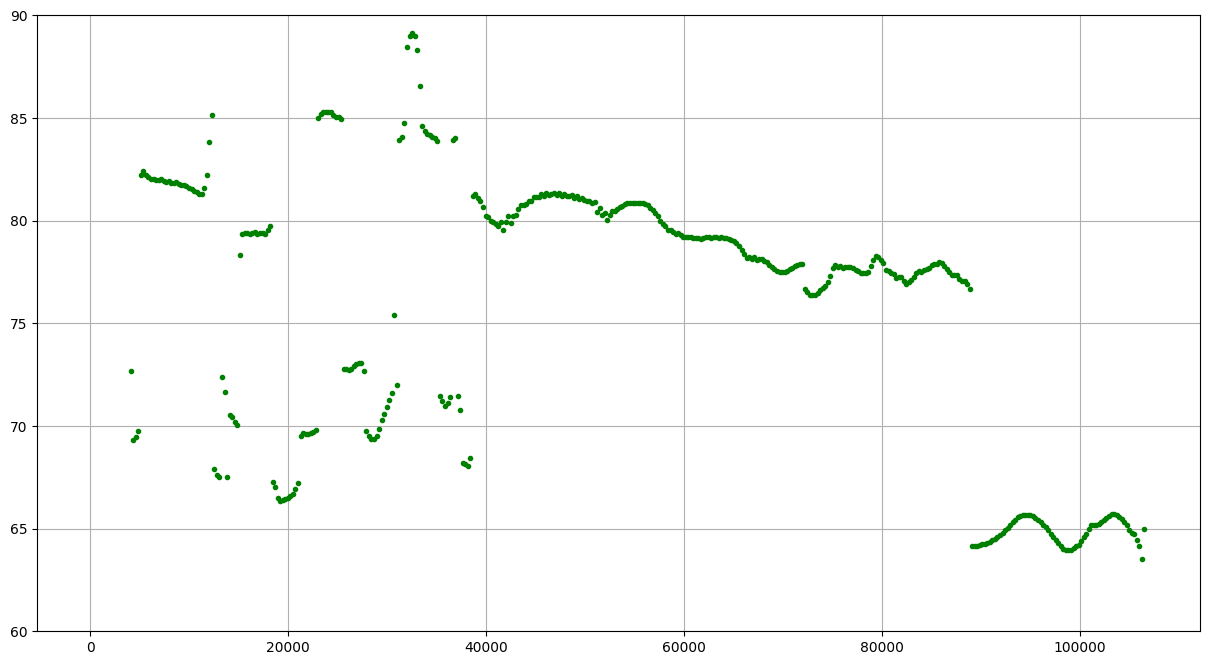

In [52]:
import sys
from aubio import source, pitch

# if len(sys.argv) < 2:
#     print("Usage: %s <filename> [samplerate]" % sys.argv[0])
#     sys.exit(1)

filename = "audios/singer.wav"

downsample = 1
samplerate = 44100 // downsample
# if len( sys.argv ) > 2: samplerate = int(sys.argv[2])

win_s = 2048 // downsample # fft size
hop_s = 256  // downsample # hop size

s = source(filename, samplerate, hop_s)
samplerate = s.samplerate

tolerance = 0.9

pitch_o = pitch("yin", win_s, hop_s, samplerate)
pitch_o.set_unit("midi")
pitch_o.set_tolerance(tolerance)

pitches = []
confidences = []

# total number of frames read
total_frames = 0
while True:
    samples, read = s()
    pitch = pitch_o(samples)[0]
    #pitch = int(round(pitch))
    confidence = pitch_o.get_confidence()
    #if confidence < 0.8: pitch = 0.
    # print("%f %f %f" % (total_frames / float(samplerate), pitch, confidence))
    pitches += [pitch]
    confidences += [confidence]
    total_frames += read
    if read < hop_s: break

# if 0: sys.exit(0)

#print pitches
import os.path
from numpy import array, ma
import matplotlib.pyplot as plt
from demo_waveform_plot import get_waveform_plot, set_xlabels_sample2time

skip = 1

pitches = array(pitches[skip:])
confidences = array(confidences[skip:])
times = [t * hop_s for t in range(len(pitches))]

# fig = plt.figure()

# ax1 = fig.add_subplot(311)
# ax1 = get_waveform_plot(filename, samplerate = samplerate, block_size = hop_s, ax = ax1)
# plt.setp(ax1.get_xticklabels(), visible = False)
# ax1.set_xlabel('')

# def array_from_text_file(filename, dtype = 'float'):
#     filename = os.path.join(os.path.dirname(__file__), filename)
#     return array([line.split() for line in open(filename).readlines()],
#         dtype = dtype)

# ax2 = fig.add_subplot(312, sharex = ax1)
# ground_truth = os.path.splitext(filename)[0] + '.f0.Corrected'
# if os.path.isfile(ground_truth):
#     ground_truth = array_from_text_file(ground_truth)
#     true_freqs = ground_truth[:,2]
#     true_freqs = ma.masked_where(true_freqs < 2, true_freqs)
#     true_times = float(samplerate) * ground_truth[:,0]
#     ax2.plot(true_times, true_freqs, 'r')
#     ax2.axis( ymin = 0.9 * true_freqs.min(), ymax = 1.1 * true_freqs.max() )
# # plot raw pitches
# ax2.plot(times, pitches, '.g')
# # plot cleaned up pitches
# cleaned_pitches = pitches
# #cleaned_pitches = ma.masked_where(cleaned_pitches < 0, cleaned_pitches)
# #cleaned_pitches = ma.masked_where(cleaned_pitches > 120, cleaned_pitches)
# cleaned_pitches = ma.masked_where(confidences < tolerance, cleaned_pitches)
# ax2.plot(times, cleaned_pitches, '.-')
# #ax2.axis( ymin = 0.9 * cleaned_pitches.min(), ymax = 1.1 * cleaned_pitches.max() )
# #ax2.axis( ymin = 55, ymax = 70 )
# plt.setp(ax2.get_xticklabels(), visible = False)
# ax2.set_ylabel('f0 (midi)')

# # plot confidence
# ax3 = fig.add_subplot(313, sharex = ax1)
# # plot the confidence
# ax3.plot(times, confidences)
# # draw a line at tolerance
# ax3.plot(times, [tolerance]*len(confidences))
# ax3.axis( xmin = times[0], xmax = times[-1])
# ax3.set_ylabel('confidence')
# set_xlabels_sample2time(ax3, times[-1], samplerate)
# plt.show()
# #plt.savefig(os.path.basename(filename) + '.svg')

# times
plt.figure(figsize = (15, 8))
plt.grid(True)
plt.ylim(60,90)
plt.plot(times, pitches, '.g')
plt.show()